# Studies of data reuse: Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization

**Liam Chan-kin and Andrew P. Davison**

Paris-Saclay Institute of Neuroscience, CNRS, Université Paris-Saclay, France.

August 2024

----

In this notebook we will look more closely at the EBRAINS dataset "[Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization (v1)](https://search.kg.ebrains.eu/#07554ebd-95a2-46f0-8065-d961d56ce098)", contributed by Machhindra Garad while at Otto-von-Guericke University, Magdeburg, Germany and Volkmar Lessmann from the Center for Behavioral Brain Sciences (CBBS), Magdeburg, Germany.

As we can see from the dataset description,

<i>This dataset provides an analysis of electrophysiological feature often observed in recordings from mouse CA1 pyramidal cells that has so far been ignored by experimentalists and modelers. It consists of a large and dynamic increase in the depolarization baseline (i.e., the minimum value of the membrane potential between successive action potentials during a sustained depolarizing input) in response to strong somatic current injections.</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/07554ebd-95a2-46f0-8065-d961d56ce098).

This dataset forms part of the results reported in:

Bianchi, D., Migliore, R., Vitale, P., Garad, M., Pousinha, P. A., Marie, H., Lessmann, V., & Migliore, M. (2022). Membrane electrical properties of mouse hippocampal CA1 pyramidal neurons during strong inputs. *Biophysical Journal*, **121**(4), 644–657. https://doi.org/10.1016/j.bpj.2022.01.002

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 

## Downloading the data

Please note that this is a 5.3 MB dataset. Over a slow connection, this could take a long time to download. If running this notebook on a shared resource such as the EBRAINS lab, you may need to delete the downloaded data after use, to avoid taking up too much disk space.

To download the data, we first search for the dataset in the EBRAINS Knowledge Graph using the [fairgraph](https://fairgraph.readthedocs.io/) tool, then download a zip file, and unzip it.

In [1]:
import os
import logging
import sys
import warnings
import zipfile

from fairgraph import KGClient
import fairgraph.openminds.core as omcore

omcore.set_error_handling(None)
warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)

# To communicate with the EBRAINS Knowledge Graph, we use a KGClient object.
# If running this notebook in the EBRAINS Lab, we can get the authorization token from the Lab environment.
token = clb_oauth.get_token()
kg_client = KGClient(host="core.kg.ebrains.eu", token=token)

In [2]:
dataset_version_doi = "10.25493/VAV5-BXU"

dataset_versions = omcore.DatasetVersion.list(
    kg_client, 
    digital_identifier__identifier=dataset_version_doi,
    follow_links={"repository": {"files": {}}},
    scope="any"
)

assert len(dataset_versions) == 1  # check: the DOI should be for a single, specific version of the dataset
dataset_version = dataset_versions[0]

# check we have the correct version of the dataset
assert dataset_version.full_name == "Excitability of mouse hippocampal CA1 pyramidal neurons during sustained (500 ms) strong depolarization"
assert dataset_version.version_identifier == "v1"

if not os.path.exists("downloads"):  # only download the dataset if it hasn't been downloaded previously
    dataset_path = dataset_version.download("downloads", kg_client, accept_terms_of_use=True)[0]
else:
    dataset_path = "downloads/d-cc88a377-b456-4673-a449-07b0e7960ffd.zip"
with zipfile.ZipFile(dataset_path, "r") as z:
    z.extractall("downloads")

## Retrieving the metadata

Metadata are stored in the Knowledge Graph. Some of the metadata is part of the `dataset_version` object we've already retrieved, but for other metadata we need to follow links in the graph. 

In [3]:
print(dataset_version.description)

In this work, we highlight an electrophysiological feature often observed in recordings from mouse CA1 pyramidal cells that has so far been ignored by experimentalists and modelers. It consists of a large and dynamic increase in the depolarization baseline (i.e., the minimum value of the membrane potential between successive action potentials during a sustained depolarizing input) in response to strong somatic current injections. Such an increased sustained depolarization can directly affect neurotransmitter release properties and, more generally, the efficacy of synaptic transmission. However, it cannot be explained by any currently available conductance-based computational model.

Here, we provide the original data describing and modeling the depolarization baseline (DBL) phenomenon and descriptions of the methods used, as reported in the related publication (Bianchi et al., 2022). This dataset entails the experiments generated in laboratory 2.


In [4]:
from fairgraph.utility import as_list

def show_linked_metadata(property):
    """This function resolves (follows) links in the graph associated with a given metadata property, 
    and returns a list of the linked metadata instances."""
    items = []
    for link in as_list(property):
        item = link.resolve(kg_client)
        items.append(item.name)
    return items

In [5]:
print("Data types:              ", show_linked_metadata(dataset_version.data_types))
print("Experimental approaches: ", show_linked_metadata(dataset_version.experimental_approaches))
print("Keywords:                ", show_linked_metadata(dataset_version.keywords))
print("Study targets:           ", show_linked_metadata(dataset_version.study_targets))
print("Techniques:              ", show_linked_metadata(dataset_version.techniques))

Data types:               ['experimental data', 'raw data']
Experimental approaches:  ['electrophysiology']
Keywords:                 ['intrinsic excitability', 'depolarization baseline']
Study targets:            ['hippocampus CA1 pyramidal neuron']
Techniques:               ['whole cell patch clamp']


We will retrieve more metadata in the course of our exploration of the data.

## Exploring and visualizing the data

Of the two laboratories whose data are shown in the associated paper (Bianchi et al., 2022), only the data from "Laboratory 2" is contained in this dataset.

The dataset contains a number of files with the extension ".abf". There are 2 subjects with different cell states.

We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique. We will therefore use the [Neo library](https://neo.readthedocs.io/) to read the data files, since it is able to read data from a large number of electrophysiology file formats.

Neo loads data into a hierarchical structure: Blocks contain Segments, which contain the actual data.

Let's look at the structure of the first three files:

In [6]:
from glob import glob
from neo import get_io

for file_path in glob("downloads/*.ABF")[:3]:
    io = get_io(file_path)
    print(io)

AxonIO: downloads/170518_1a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_3a.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]

AxonIO: downloads/170529_2e.ABF
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 1)]
signal_channels: []
spike_channels: []
event_channels: [Tag]



These all have a consistent structure: they're in Axon format, and contain a single block containing 1 segment.
We know from the associated paper that current pulses of increasing intensity were injected into the neurons, in steps of 50 pA from 0 to 450 pA. We can also retrieve this information directly from the Knowledge Graph:

In [7]:
import json
import fairgraph.openminds.stimulation as stim

# Metadata about each experimental activity is stored in the "has_parts" property of the dataset version metadata.
# Here we filter out only stimulation activities, so that we can retrieve information about the stimuli used.
stimulation_activities = [
    activity.resolve(kg_client, scope="any", follow_links={"stimuli": {}}) 
    for activity in dataset_version.has_parts 
    if stim.StimulationActivity in activity.classes
]
stimulus = stimulation_activities[0].stimuli.resolve(kg_client, scope="any")

In [8]:
print(stimulus.description, "\n")
stimulus_config = json.loads(stimulus.specifications.resolve(kg_client, scope="any").configuration)
stimulus_config

The intrinsic excitability of CA1 pyramidal neurons was assessed by action potential frequency readout in response to 0–450 pA (50-pA increments, repeated five times for each current injection at 5-s intervals) depolarizing somatic current injections for 500-ms duration in current-clamp mode from the endogenous resting membrane potential. 



{'onset': 100,
 'duration': 500,
 'interval': 700,
 'amplitudes': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450],
 'time_units': 'ms',
 'amplitude_units': 'pA'}

So it seems likely that the segment contains the responses to all current pulses for a given repeat. We will assume at this point that all the signals are similar, and take a closer look at one of them.

In [9]:
data = get_io("downloads/170529_1b.ABF").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

AnalogSignal with 1 channels of length 70000; units mV; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.0 s to 7.0 s

In patch clamp recording, it often happens that raw recorded traces need to be corrected because of the liquid junction potential.
For more information on the liquid junction potential, we can look this term up in the EBRAINS Knowledge Graph:

In [10]:
import fairgraph.openminds.controlled_terms as terms

ljp_term = terms.MeasuredQuantity.by_name("liquid junction potential", kg_client)
ljp_term.definition

'A potential difference that develops when two solutions of electrolytes of different concentrations are in contact with each other.'

We can also retrieve the measured value of the liquid junction potential from the dataset metadata:

In [11]:
import fairgraph.openminds.ephys as ephys

file_170529_1b = [f for f in dataset_version.repository.files if "170529_1b" in f.name][0]
recording_info = file_170529_1b.is_location_of.resolve(kg_client, scope="any", follow_links={"recorded_with": {}})

In [12]:
import quantities as pq

ljp_unit_name = recording_info.recorded_with.liquid_junction_potential.values.unit.resolve(kg_client).name
ljp_unit = getattr(pq, ljp_unit_name)

In [13]:
ljp_correction = recording_info.recorded_with.liquid_junction_potential.values.value * ljp_unit
ljp_correction

array(-10.) * mV

Now let's plot the data from one of the files:

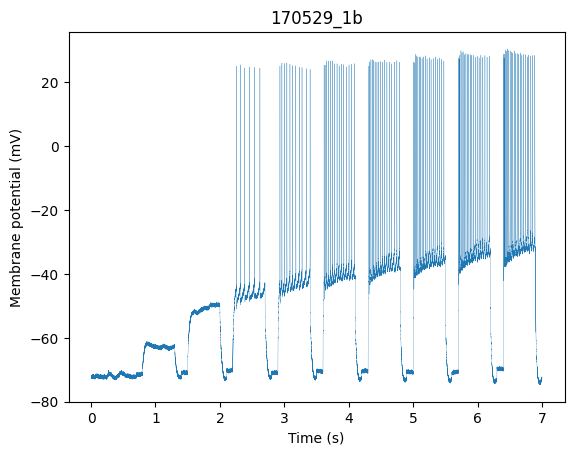

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_data(file_path, title): 
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load() + ljp_correction
        plt.plot(signal.times, signal, lw=0.2)
    plt.title(title)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")
    
plot_data("downloads/170529_1b.ABF", title="170529_1b")

## Figure 1

Figure 1 shows the DBL (depolarization baseline) increases with current injection. To get a closer look at the signals, we can slice the signal to get each current injection independently, and plot only the 700 ms around the current injection:

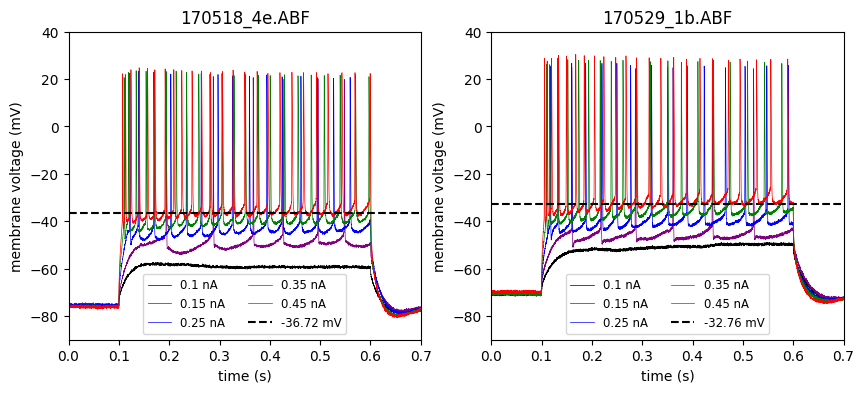

In [15]:
time_units = getattr(pq, stimulus_config["time_units"])
stimulus_interval = stimulus_config["interval"] * time_units.rescale(pq.s)  # convert from ms to seconds
current_pulse_amplitudes = stimulus_config["amplitudes"]

def get_trace(signal, stimulus_amplitude):
    """Extract the section of the signal corresponding to a current injection of the given amplitude"""
    index = current_pulse_amplitudes.index(stimulus_amplitude)
    stim_onset = index * stimulus_interval
    stim_offset = (index + 1) * stimulus_interval
    return signal.time_slice(stim_onset, stim_offset)

def plot_data_zoom(ax, file_path, liquid_junction_potential_correction, show_amplitudes, line_colours, dbl_level):
    # Read the data
    data = get_io(file_path).read(lazy=True)
    # Apply the liquid junction potential correction
    signal = data[0].segments[0].analogsignals[0].load() + liquid_junction_potential_correction
    # Plot the sections of the signal that correspond to specific stimulus amplitudes
    for stimulus_amplitude, colour in zip(show_amplitudes, line_colours):
        trace = get_trace(signal, stimulus_amplitude)
        ax.plot(trace.times - trace.t_start, trace, lw=0.5, color=colour, label=f"{stimulus_amplitude/1000} nA")
    # Add a horizontal line indicating the depolarization baseline (DBL)
    ax.axhline(y=dbl_level, color='black', linestyle='--', label=f'{dbl_level} mV')
    # Adjust the figure axes, legend and labels
    ax.set_xlim(0.0, stimulus_interval)
    ax.set_ylim(-90, 40)
    ax.set_xlabel(f"time ({signal.times.units.dimensionality})")
    ax.set_ylabel(f"membrane voltage ({signal.units.dimensionality})")
    ax.legend(loc="lower center", ncol=2, fontsize='small')
    ax.set_title(file_path.split("/")[1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
dbl_levels = [-36.72, -32.76]  # todo: calculate the DBL levels from the data, here we take the values shown in the paper

for file_path, ax, dbl in zip(("downloads/170518_4e.ABF", "downloads/170529_1b.ABF"), axes, dbl_levels): 
    plot_data_zoom(
        ax,
        file_path=file_path, 
        liquid_junction_potential_correction=ljp_correction,
        show_amplitudes=[100, 150, 250, 350, 450], 
        line_colours=["black", "purple", "blue", "green", "red"],
        dbl_level=dbl
    )

Here is the original Figure 1 Laboratory 2 for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article).

We can see the same results between the original figure and the reproduction. The only difference is the units in the legend, which appear to be incorrect in the original figure.

![fig1](original_fig1_lab2.png "Original Figure 1 Lab2")

## Figure 2

### Calculation of the depolarization baseline (DBL)

Bianchi et al. (2022) does not describe how the calculation of DBL was performed, so we take here a reasonable but perhaps simplified approach.
The details of the calculation of the DBL are given in the function docstring below. 
It is unlikely that the method used here matches exactly that used in that paper, but we expect it to give similar results.

**EXERCISE**: Experiment with changing the ``file_path`` and the injected current level to see how the method works with different recordings.

-48.51658630371094

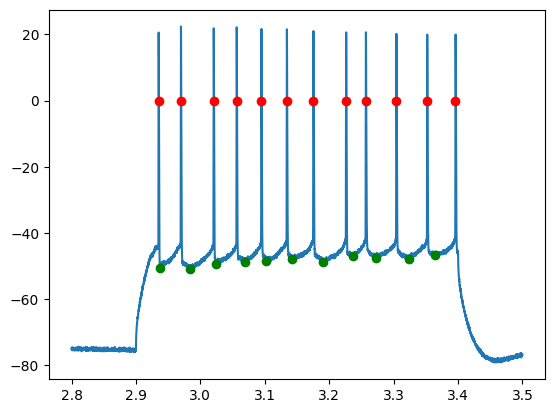

In [16]:
import numpy as np

def get_dbl(trace, with_plot=False):
    """
    Calculate the depolarization baseline (DBL).

    If the trace contains spikes, we calculate the array of minimum values of the 
    membrane voltage between spikes (note that this could be improved using averaging/smoothing, 
    as it does not take account of noise in the trace), and return the mean of this array.

    If the trace does not contain spikes, we return the mean membrane potential 
    during the final 400 ms of the pulse (missing out the initial transient).
    """

    # Note that "trace" is a Neo AnalogSignal (a 2D array with units and other metadata). 
    # To transform it into an array we take the magnitude and then "flatten" it with ravel()
    crossings = np.diff(trace.magnitude.ravel() > 0, prepend=False)
    crossing_indices = np.argwhere(crossings)[::2].ravel()  # only positive crossings
    crossing_times = trace.times[crossing_indices]
    
    dbl_index = np.array([
       start + np.argmin(trace.magnitude.ravel()[start:end])
       for start, end in zip(crossing_indices[:-1], crossing_indices[1:])
    ])
    
    if len(dbl_index) > 0:
        dbl = trace.view(pq.Quantity).ravel()[dbl_index]
        if with_plot:
            plt.plot(trace.times, trace)
            plt.plot(crossing_times, np.zeros_like(crossing_times), "ro")
            plt.plot(trace.times[dbl_index], dbl, "go")
        dbl = dbl.mean().item()
    else: # todo: take the mean Vm during the pulse
        start = trace.t_start + (stimulus_config["onset"] + 100) * time_units
        end = trace.t_start + (stimulus_config["duration"] - 100) * time_units
        dbl = trace.time_slice(start, end).mean().item()
        if with_plot:
            plt.plot(trace.times, trace)
            plt.axhline(dbl, color="green", lw=2)
    return dbl

file_path = "downloads/170518_4e.ABF"
data = get_io(file_path).read()
signal = data[0].segments[0].analogsignals[0] + ljp_correction
trace = get_trace(signal, 200)
dbl = get_dbl(trace, with_plot=True)
dbl

**EXERCISE**: modify the function to apply some smoothing to the traces between the action potentials; 
this should reduce the tendency of noise to lower the DBL (since the min() function takes the extreme of the noise.

### Plot DBL for all recordings 

In [17]:
dbl_by_recording = {}

for file_path in glob("downloads/*.ABF"):
    recording_id, ext = os.path.splitext(os.path.basename(file_path))
    data = get_io(file_path).read()
    signal = data[0].segments[0].analogsignals[0] + ljp_correction
    dbl_by_recording[recording_id] = [
        get_dbl(
            get_trace(signal, cpa)
        ) 
        for cpa in current_pulse_amplitudes
    ]

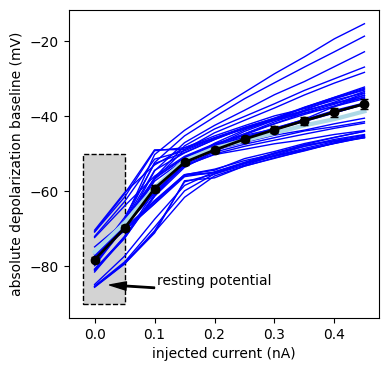

In [18]:
from matplotlib.patches import Rectangle

injected_current = pq.Quantity(current_pulse_amplitudes, stimulus_config["amplitude_units"]).rescale("nA")
dbl_data = np.array(list(dbl_by_recording.values()))
dbl_mean = dbl_data.mean(axis=0)
assert dbl_data.shape[0] == 35, dbl_data.shape
dbl_sem = np.std(dbl_data, ddof=1, axis=0) / np.sqrt(dbl_data.shape[0])

fig, ax = plt.subplots(figsize=(4, 4))
for recording_id in dbl_by_recording:
    ax.plot(injected_current, dbl_by_recording[recording_id], color='blue', linewidth=1)
ax.plot(injected_current, dbl_by_recording['170518_4e'], color='lightblue', linewidth=3)
ax.errorbar(injected_current, dbl_mean, yerr=dbl_sem, fmt='o-', color='black', linewidth=2, capsize=3)

rest_pot = Rectangle((-0.02, -90), 0.07, 40, linewidth=1, edgecolor = 'black', facecolor='lightgray', linestyle='--')
ax.add_patch(rest_pot)
ax.annotate('resting potential', xy=(0.025, -85), xytext=(0.2, -85),
            arrowprops=dict(facecolor='black', shrink=0, width=1, headwidth=6), 
            fontsize=10, ha='center')

ax.set_yticks(np.arange(-80, 0, 20))
plt.xlabel("injected current (nA)")
plt.ylabel("absolute depolarization baseline (mV)")
plt.show()

Here is the original Figure 2A for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article). The calculated DBL for Laboratory 2 appear to be a close match, except for the mean value at 0.1 nA, which is at the extreme edge of the distribution in the original figure.
 
![fig2A](original_fig2A.png "Original Figure 2A")

## Summary

In this notebook, we have demonstrated how to access the dataset, and how to read the data files. We have partially reproduced some of the figures from a published paper to which the data contributed. We leave reproduction of some of the other figures from the paper as an exercise for the reader.